### signal sharing

how often are pcqtls picking up on new signals vs the same eqtl signals? how often are they multigene eqtl signals?

can group around

* shared lead variant (old version)
* colocalizaion (new version)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import networkx as nx


import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

In [ ]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# load in the tissue ids 
tissue_ids = load_tissue_ids(config)

## load data for old susie/lead varaint method

In [3]:
pc_susie = load_across_tissues(config, load_pc_susie, tissue_ids = tissue_ids[0:1])
e_susie = load_across_tissues(config, load_e_susie, tissue_ids = tissue_ids[0:1])

In [4]:
# e and pcqtl signals in each 
combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first', 'variant_id':list}).reset_index()
print(len(credible_sets))

3166


## lead variant sharing

In [5]:
# add lead var overlap information
lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
lead_var_grouped['num_e_samelead'] = lead_var_grouped['type'].astype(str).str.count('eQTL')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['type'].astype(str).str.count('pcQTL')
lead_var_grouped['multiple_e'] = lead_var_grouped['num_e_samelead'] > 1
lead_var_grouped['multiple_pc'] = lead_var_grouped['num_pc_samelead'] > 1
lead_var_grouped['eQTL'] = lead_var_grouped['num_e_samelead'] > 0
lead_var_grouped['pcQTL'] = lead_var_grouped['num_pc_samelead'] > 0

credible_sets = lead_var_grouped.explode(['cs_id', 'type'])
print(len(lead_var_grouped))

2392


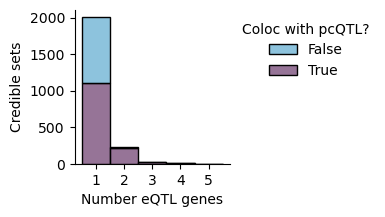

In [8]:
fig, ax = plt.subplots(figsize=(2,2))
sns.histplot(credible_sets[(credible_sets['num_e_samelead'] > 0)], x='num_e_samelead', hue='pcQTL', 
             multiple='stack', bins=range(1,7), palette={False:'#67AFD2', True:'#734675'},)

ax.set_xlabel('Number eQTL genes')
ax.set_ylabel('Credible sets')


# Change legend title
leg = ax.get_legend()
leg.set_title('Coloc with pcQTL?')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

ax.set_xticks([1.5,2.5,3.5,4.5, 5.5], [1,2,3,4, 5])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


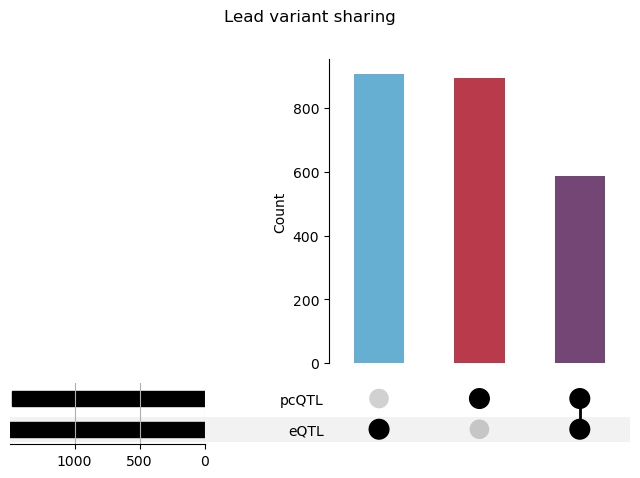

In [43]:
lead_var_grouped['upset_color_label'] = np.where(lead_var_grouped['num_e_samelead'] > 0, np.where(lead_var_grouped['num_pc_samelead'] > 0, 'shared', 'eqtl_only'), 'pcqtl_only')
upset = lead_var_grouped.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label", title="Count", elements=8, colors=('#67AFD2','#B83A4B', '#734675'))

upset.plot(fig=fig)

plt.grid(False)
plt.legend([],[], frameon=False)



plt.suptitle('Lead variant sharing')
plt.show()

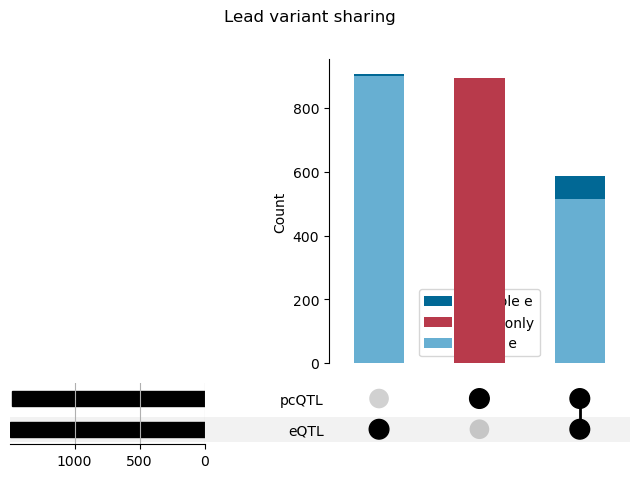

In [53]:
lead_var_grouped['multiple_e_color_label'] = np.where(lead_var_grouped['num_e_samelead'] > 1, 'multiple e', np.where(lead_var_grouped['num_e_samelead'] > 0, 'single e', 'pcqtl_only'))
upset = lead_var_grouped.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=8, colors=('#016895','#B83A4B', '#67AFD2'))

upset.plot(fig=fig)

plt.grid(False)



plt.suptitle('Lead variant sharing')
plt.show()

In [44]:
lead_var_grouped['upset_color_label_multiple'] = lead_var_grouped['upset_color_label']
lead_var_grouped.loc[((lead_var_grouped['upset_color_label'] == 'shared') & (lead_var_grouped['num_e_samelead'] > 1)),'upset_color_label_multiple'] = 'multiple_e_and_pc'
lead_var_grouped.loc[((lead_var_grouped['upset_color_label'] == 'eqtl_only') & (lead_var_grouped['num_e_samelead'] > 1)),'upset_color_label_multiple'] = 'multiple_e'

lead_var_grouped['upset_color_label_multiple'] = pd.Categorical(lead_var_grouped['upset_color_label_multiple'] ,
                                                                ['multiple_e', 'eqtl_only', 'pcqtl_only', 'multiple_e_and_pc', 'shared'])

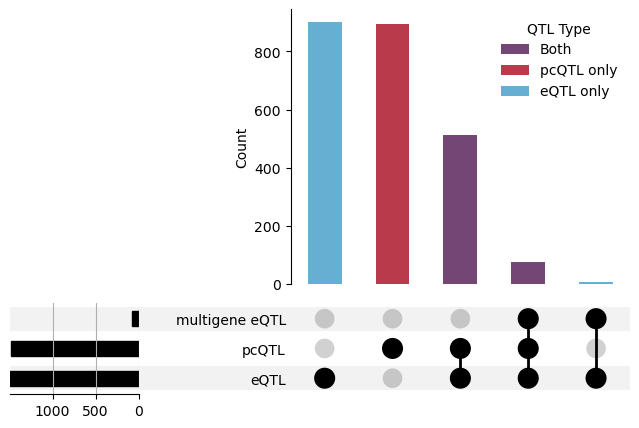

In [57]:
lead_var_grouped['multigene eQTL'] = lead_var_grouped['multiple_e']
upset = lead_var_grouped.set_index('eQTL').set_index('pcQTL', append=True).set_index('multigene eQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label", title="Count", elements=8, colors=('#67AFD2','#B83A4B', '#734675'))

upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper right')
leg = plt.gca().get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['Both', 'pcQTL only', 'eQTL only']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
leg.set_frame_on(False)


plt.show()

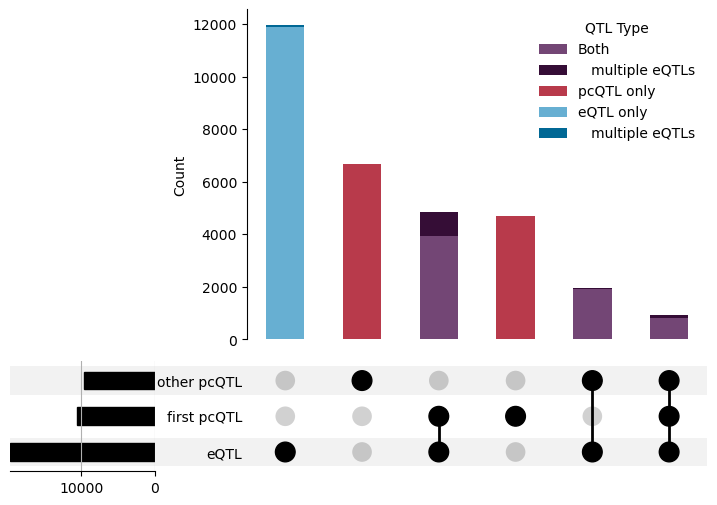

In [13]:
# split out by pc type
lead_var_grouped['first pcQTL'] = lead_var_grouped['cs_id'].astype(str).str.contains('pc1')
lead_var_grouped['other pcQTL'] = (~lead_var_grouped['first pcQTL'] & lead_var_grouped['pcQTL'] )| lead_var_grouped['multiple_pc']

upset = lead_var_grouped.set_index('eQTL').set_index('first pcQTL', append=True).set_index('other pcQTL', append=True)
fig = plt.figure(figsize=(9,6))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None, min_subset_size=100, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label_multiple", title="Count", elements=8, colors=('#016895','#67AFD2', '#B83A4B', '#350D36',  '#734675',))



upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper right')
leg = plt.gca().get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['Both', '   multiple eQTLs', 'pcQTL only', 'eQTL only','   multiple eQTLs']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
leg.set_frame_on(False)

plt.show()

## Pairwise colocs

In [9]:
my_tissue_id = ['Thyroid', 'Lung', 'Whole_Blood']

In [10]:
underlying_signals = load_across_tissues(config, load_signal_groups, tissue_ids = my_tissue_id)

Text(0.5, 0, 'Number credible sets colocd')

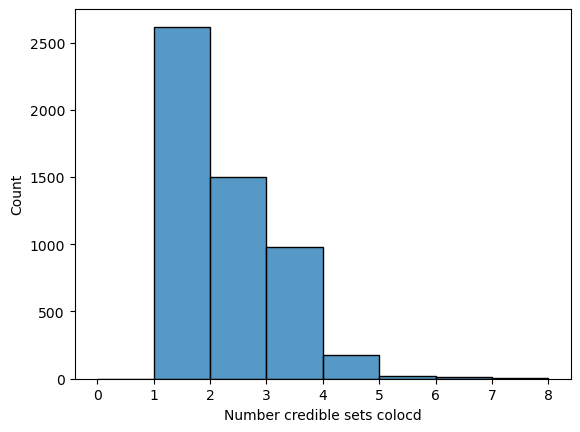

In [11]:
# distiburion of number of colocs per credible set
num_signals = [len(signal.split('-')) for signal in underlying_signals['signal_id']]
ax = sns.histplot(num_signals, bins=range(0, max(num_signals)))
ax.set_xlabel('Number credible sets colocd')

In [12]:
underlying_signals['upset_color_label'] = np.where(underlying_signals['num_e_samelead'] > 0, np.where(underlying_signals['num_pc_samelead'] > 0, 'shared', 'eqtl_only'), 'pcqtl_only')
underlying_signals['upset_color_label_multiple'] = underlying_signals['upset_color_label']
underlying_signals.loc[((underlying_signals['upset_color_label'] == 'shared') & (underlying_signals['num_e_samelead'] > 1)),'upset_color_label_multiple'] = 'multiple_e_and_pc'
underlying_signals.loc[((underlying_signals['upset_color_label'] == 'eqtl_only') & (underlying_signals['num_e_samelead'] > 1)),'upset_color_label_multiple'] = 'multiple_e'

underlying_signals['upset_color_label_multiple'] = pd.Categorical(underlying_signals['upset_color_label_multiple'] ,
                                                                ['multiple_e', 'eqtl_only', 'pcqtl_only', 'multiple_e_and_pc', 'shared'])

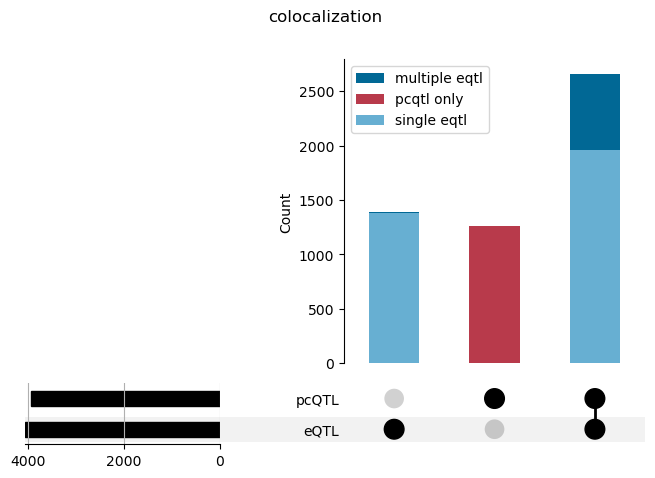

In [13]:
underlying_signals['multiple_e_color_label'] = np.where(underlying_signals['num_e_samelead'] > 1, 'multiple eqtl', np.where(underlying_signals['num_e_samelead'] > 0, 'single eqtl', 'pcqtl only'))
underlying_signals['eQTL'] = underlying_signals['num_e_samelead'] > 0
underlying_signals['pcQTL'] = underlying_signals['num_pc_samelead'] > 0
upset = underlying_signals.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=8, colors=('#016895','#B83A4B', '#67AFD2'))

upset.plot(fig=fig)

plt.grid(False)



plt.suptitle('colocalization')
plt.show()


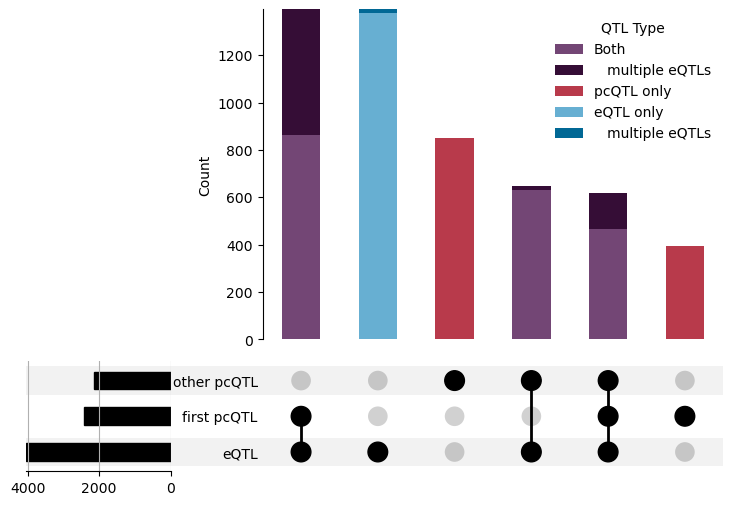

In [14]:
# broken over pc type
underlying_signals['first pcQTL'] = underlying_signals['signal_id'].astype(str).str.contains('pc1')
underlying_signals['other pcQTL'] = (~underlying_signals['first pcQTL'] & underlying_signals['pcQTL'] )| (underlying_signals['num_pc_samelead'] > 1)

upset = underlying_signals.set_index('eQTL').set_index('first pcQTL', append=True).set_index('other pcQTL', append=True)
fig = plt.figure(figsize=(9,6))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None, min_subset_size=100, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label_multiple", title="Count", elements=8, colors=('#016895','#67AFD2', '#B83A4B', '#350D36',  '#734675',))



upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper right')
leg = plt.gca().get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['Both', '   multiple eQTLs', 'pcQTL only', 'eQTL only','   multiple eQTLs']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
leg.set_frame_on(False)

plt.show()
